# **Audio Tagging**

# Table of content

## **<div id="I">I. Define the problem</div>**

### **<div id="I0">0. Sources</div>**

https://medium.com/@ageitgey/machine-learning-is-fun-part-6-how-to-do-speech-recognition-with-deep-learning-28293c162f7a
https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced
https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai

### **<div id="I1">1. Problem description</div>**

One year ago, Freesound and Google’s Machine Perception hosted an audio tagging competition challenging Kagglers to build a general-purpose auto tagging system. This year they’re back and taking the challenge to the next level with multi-label audio tagging, doubled number of audio categories, and a noisier than ever training set.

![](https://storage.googleapis.com/kaggle-media/competitions/freesound/task2_freesound_audio_tagging.png)

Here's the background: Some sounds are distinct and instantly recognizable, like a baby’s laugh or the strum of a guitar. Other sounds are difficult to pinpoint. If you close your eyes, could you tell the difference between the sound of a chainsaw and the sound of a blender?

Because of the vastness of sounds we experience, no reliable automatic general-purpose audio tagging systems exist. A significant amount of manual effort goes into tasks like annotating sound collections and providing captions for non-speech events in audiovisual content.

To tackle this problem, Freesound (an initiative by MTG-UPF that maintains a collaborative database with over 400,000 Creative Commons Licensed sounds) and Google Research’s Machine Perception Team (creators of AudioSet, a large-scale dataset of manually annotated audio events with over 500 classes) have teamed up to develop the dataset for this new competition.

To win this competition, Kagglers will develop an algorithm to tag audio data automatically using a diverse vocabulary of 80 categories.

If successful, your systems could be used for several applications, ranging from automatic labelling of sound collections to the development of systems that automatically tag video content or recognize sound events happening in real time.

### **<div id="I2">2. Tools importing</div>**

Here we are importing every useful tool needed during our research process.

In [1]:
import time
start_time = time.time()

# Data analysis and wrangling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import IPython.display
import librosa
import librosa.display
import random
from tqdm import tqdm_notebook
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
from fastai.imports import *
from fastai.callback import *
from fastai.callbacks import *

# Machine learning
from sklearn import preprocessing
import sklearn.metrics
from sklearn.metrics import label_ranking_average_precision_score

# File handling
from pathlib import Path
import gc
import os
print(os.listdir("../input"))

['train_noisy', 'sample_submission.csv', 'train_curated', 'train_curated.csv', 'train_noisy.csv', 'test']


### **<div id="I3">3. Label ranking average precision</div>**

The task consists of predicting the audio labels (tags) for every test clip. Some test clips bear one label while others bear several labels. The predictions are to be done at the clip level, i.e., no start/end timestamps for the sound events are required.

The primary competition metric will be label-weighted label-ranking average precision (lwlrap, pronounced "Lol wrap"). This measures the average precision of retrieving a ranked list of relevant labels for each test clip (i.e., the system ranks all the available labels, then the precisions of the ranked lists down to each true label are averaged). This is a generalization of the mean reciprocal rank measure (used in last year’s edition of the competition) for the case where there can be multiple true labels per test item. The novel "label-weighted" part means that the overall score is the average over all the labels in the test set, where each label receives equal weight (by contrast, plain lrap gives each test item equal weight, thereby discounting the contribution of individual labels when they appear on the same item as multiple other labels).

We use label weighting because it allows per-class values to be calculated, and still have the overall metric be expressed as simple average of the per-class metrics (weighted by each label's prior in the test set). For participant’s convenience, a Python implementation of lwlrap is provided in this public Google Colab.

In [2]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

### **<div id="I4">4. Data</div>**

#### **Train set**

The train set is meant to be for system development. The idea is to limit the supervision provided (i.e., the manually-labeled data), thus promoting approaches to deal with label noise. The train set is composed of two subsets as follows:

**Curated subset**

The curated subset is a small set of manually-labeled data from FSD.
* Number of clips/class: 75 except in a few cases (where there are less)
* Total number of clips: 4970
* Avge number of labels/clip: 1.2
* Total duration: 10.5 hours

The duration of the audio clips ranges from 0.3 to 30s due to the diversity of the sound categories and the preferences of Freesound users when recording/uploading sounds. It can happen that a few of these audio clips present additional acoustic material beyond the provided ground truth label(s).

**Noisy subset**

The noisy subset is a larger set of noisy web audio data from Flickr videos taken from the YFCC dataset.
* Number of clips/class: 300
* Total number of clips: 19815
* Avge number of labels/clip: 1.2
* Total duration: ~80 hours

The duration of the audio clips ranges from 1s to 15s, with the vast majority lasting 15s.

Considering the numbers above, per-class data distribution available for training is, for most of the classes, 300 clips from the noisy subset and 75 clips from the curated subset, which means 80% noisy - 20% curated at the clip level (not at the audio duration level, considering the variable-length clips).

#### **Test set**

The test set is used for system evaluation and consists of manually-labeled data from FSD. Since most of the train data come from YFCC, some acoustic domain mismatch between the train and test set can be expected. All the acoustic material present in the test set is labeled, except human error, considering the vocabulary of 80 classes used in the competition.

The test set is split into two subsets, for the public and private leaderboards. In this competition, the submission is to be made through Kaggle Kernels. Only the test subset corresponding to the public leaderboard is provided (without ground truth).

Submissions must be made with inference models running in Kaggle Kernels. However, participants can decide to train also in the Kaggle Kernels or offline (see Kernels Requirements for details).

This is a kernels-only competition with two stages. The first stage comprehends the submission period until the deadline on June 10th. After the deadline, in the second stage, Kaggle will rerun your selected kernels on an unseen test set. The second-stage test set is approximately three times the size of the first. You should plan your kernel's memory, disk, and runtime footprint accordingly.

#### **Files**

* train_curated.csv - ground truth labels for the curated subset of the training audio files (see Data Fields below)
* train_noisy.csv - ground truth labels for the noisy subset of the training audio files (see Data Fields below)
* sample_submission.csv - a sample submission file in the correct format, including the correct sorting of the sound categories; it contains the list of audio files found in the test.zip folder (corresponding to the public leaderboard)
* train_curated.zip - a folder containing the audio (.wav) training files of the curated subset
* train_noisy.zip - a folder containing the audio (.wav) training files of the noisy subset
* test.zip - a folder containing the audio (.wav) test files for the public leaderboard

#### **Columns**

Each row of the train_curated.csv and train_noisy.csv files contains the following information:

* fname: the audio file name, eg, 0006ae4e.wav
* labels: the audio classification label(s) (ground truth). Note that the number of labels per clip can be one, eg, Bark or more, eg, "Walk_and_footsteps,Slam".


## **<div id="II">II. Gather the data</div>**

We start by acquiring the training and testing datasets into Pandas DataFrames. We also combine these datasets to run certain operations on both datasets together.

In [3]:
training_curated_df = pd.read_csv("../input/train_curated.csv")
training_noisy_df = pd.read_csv("../input/train_noisy.csv")
training_df = [training_curated_df, training_noisy_df]
testing_df = pd.read_csv('../input/sample_submission.csv')

In [4]:
Path('trn_curated').mkdir(exist_ok=True, parents=True)
Path('trn_noisy').mkdir(exist_ok=True, parents=True)
Path('test').mkdir(exist_ok=True, parents=True)

## **<div id="III">III. Wrangle, cleanse and Prepare Data for Consumption</div>**

In [5]:
# preview the data
training_curated_df.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [6]:
# preview the data
training_noisy_df.head()

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)
1,000b6cfb.wav,Motorcycle
2,00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,0019adae.wav,Raindrop


In [7]:
training_curated_df.info()
print('_'*40)
training_noisy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4970 entries, 0 to 4969
Data columns (total 2 columns):
fname     4970 non-null object
labels    4970 non-null object
dtypes: object(2)
memory usage: 77.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19815 entries, 0 to 19814
Data columns (total 2 columns):
fname     19815 non-null object
labels    19815 non-null object
dtypes: object(2)
memory usage: 309.7+ KB


In [8]:
labels_curated = training_curated_df['labels'].unique()
print(labels_curated.shape)
print('_'*40)
print(labels_curated)

(213,)
________________________________________
['Bark' 'Raindrop' 'Finger_snapping' 'Run' ... 'Bathtub_(filling_or_washing),Child_speech_and_kid_speaking'
 'Tap,Dishes_and_pots_and_pans,Chink_and_clink' 'Meow,Bathtub_(filling_or_washing)' 'Slam,Bus']


In [9]:
labels_noisy = training_noisy_df['labels'].unique()
print(labels_noisy.shape)
print('_'*40)
print(labels_noisy)

(1168,)
________________________________________
['Bathtub_(filling_or_washing)' 'Motorcycle' 'Marimba_and_xylophone,Glockenspiel'
 'Water_tap_and_faucet,Sink_(filling_or_washing)' ... 'Computer_keyboard,Drip' 'Zipper_(clothing),Sneeze,Scissors'
 'Gasp,Sigh,Chirp_and_tweet' 'Tap,Cupboard_open_or_close,Clapping,Slam']


In [10]:
training_curated_df.describe()

,fname,labels
count,4970,4970
unique,4970,213
top,082b10d7.wav,Computer_keyboard
freq,1,75


## **<div id="IV">IV. Turning sound into bits</div>**

### **<div id="IV1">1. Sampling sound data</div>**

The first step in speech recognition is obvious — we need to feed sound waves into a computer. But sound is transmitted as waves. How do we turn sound waves into numbers?

![](https://cdn-images-1.medium.com/max/1200/1*6_q1VIVJuavYa-9Uby_L-A.png)

Sound waves are one-dimensional. At every moment in time, they have a single value based on the height of the wave. To turn this sound wave into numbers, we just record of the height of the wave at equally-spaced points.

This is called **sampling**. We are taking a reading thousands of times a second and recording a number representing the height of the sound wave at that point in time. That’s basically all an uncompressed .wav audio file is.

“CD Quality” audio is sampled at 44.1khz (44,100 readings per second). For our problem, here is how we will proceed:
* Handle sampling rate 44.1kHz as is, no information loss.
* Size of each file will be 128 x L, L is audio seconds x 128; [128, 256] if sound is 2s long.

### **<div id="IV2">2. Pre-processing our sampled Sound Data</div>**

We now have an array of numbers with each number representing the sound wave’s amplitude at 1/44100th of a second intervals.

We could feed these numbers right into a neural network. But trying to recognize speech patterns by processing these samples directly is difficult. Instead, we can make the problem easier by doing some pre-processing on the audio data.

To make this data easier for a neural network to process, we are going to break apart this complex sound wave into it’s component parts. We’ll break out the low-pitched parts, the next-lowest-pitched-parts, and so on. Then by adding up how much energy is in each of those frequency bands (from low to high), we create a fingerprint of sorts for this audio snippet.

We do this using a mathematic operation called a Fourier transform. It breaks apart the complex sound wave into the simple sound waves that make it up. Once we have those individual sound waves, we add up how much energy is contained in each one.

The end result is a score of how important each frequency range is, from low pitch (i.e. bass notes) to high pitch.

![](https://cdn-images-1.medium.com/max/1200/1*A4CxgdyqYd_nrF3e-7ETWA.png)

If we repeat this process on every 20 millisecond chunk of audio, we end up with a spectrogram. This is what we have done below on one of our audio sound.

In [11]:
#EasyDict allows to access dict values as attributes (works recursively). A Javascript-like properties dot notation for python dicts.
#It is mandatory in order to use the library below
# Special thanks to https://github.com/makinacorpus/easydict/blob/master/easydict/__init__.py
class EasyDict(dict):

    def __init__(self, d=None, **kwargs):
        if d is None:
            d = {}
        if kwargs:
            d.update(**kwargs)
        for k, v in d.items():
            setattr(self, k, v)
        # Class attributes
        for k in self.__class__.__dict__.keys():
            if not (k.startswith('__') and k.endswith('__')) and not k in ('update', 'pop'):
                setattr(self, k, getattr(self, k))

    def __setattr__(self, name, value):
        if isinstance(value, (list, tuple)):
            value = [self.__class__(x)
                     if isinstance(x, dict) else x for x in value]
        elif isinstance(value, dict) and not isinstance(value, self.__class__):
            value = self.__class__(value)
        super(EasyDict, self).__setattr__(name, value)
        super(EasyDict, self).__setitem__(name, value)

    __setitem__ = __setattr__

    def update(self, e=None, **f):
        d = e or dict()
        d.update(f)
        for k in d:
            setattr(self, k, d[k])

    def pop(self, k, d=None):
        delattr(self, k)
        return super(EasyDict, self).pop(k, d)

In [12]:
#Thanks to https://github.com/daisukelab/ml-sound-classifier
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate) #Loads an audio file as a floating point time series. This functions samples the sound
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32) #Returns an 128 x L array corresponding to the spectrogram of the sound (L = 128*n° of s)
    return spectrogram

def melspectrogram_to_delta(mels):
    return librosa.feature.delta(mels)

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        delta = melspectrogram_to_delta(mels)
        delta_squared = melspectrogram_to_delta(delta)
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
        show_melspectrogram(conf, delta)
        show_melspectrogram(conf, delta_squared)
    return mels

conf = EasyDict()
conf.sampling_rate = 44100
conf.duration = 2
conf.hop_length = 347 * conf.duration # to make time steps 128
conf.fmin = 20
conf.fmax = conf.sampling_rate // 2
conf.n_mels = 128
conf.n_fft = conf.n_mels * 20
conf.samples = conf.sampling_rate * conf.duration

[0.000000e+00 0.000000e+00 0.000000e+00 6.103516e-05 ... 0.000000e+00 0.000000e+00 3.051758e-05 6.103516e-05]
________________________________________
[[-36.900196 -35.321175 -28.177296 -28.152235 ... -23.489868 -25.105406 -26.36702  -37.434998]
 [-38.14943  -33.399582 -28.178093 -25.097277 ... -32.9863   -30.57023  -33.5495   -44.55112 ]
 [-40.623795 -36.242844 -35.76562  -31.206263 ... -40.31035  -39.320126 -42.69505  -47.88203 ]
 [-52.460518 -45.481365 -36.476948 -33.264835 ... -41.083477 -46.757675 -46.75024  -49.29346 ]
 ...
 [-64.98361  -64.98361  -64.98361  -64.98361  ... -64.98361  -64.98361  -64.98361  -64.98361 ]
 [-64.98361  -64.98361  -64.98361  -64.98361  ... -64.98361  -64.98361  -64.98361  -64.98361 ]
 [-64.98361  -64.98361  -64.98361  -64.98361  ... -64.98361  -64.98361  -64.98361  -64.98361 ]
 [-64.98361  -64.98361  -64.98361  -64.98361  ... -64.98361  -64.98361  -64.98361  -64.98361 ]]
(128, 448)


/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


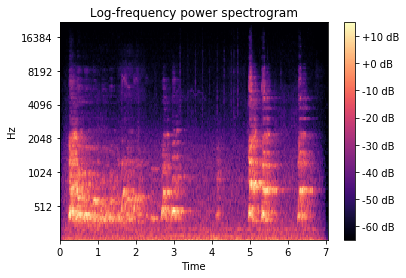

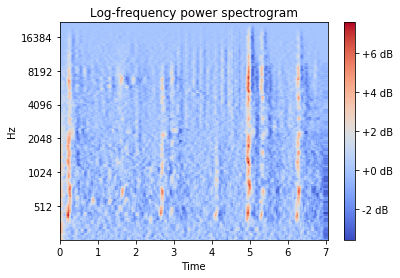

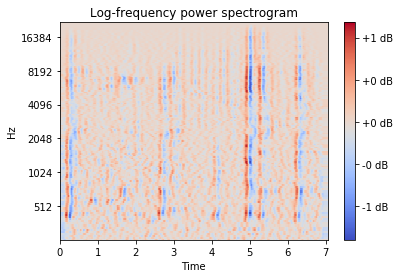

In [13]:
# example
path = '../input/train_curated/0006ae4e.wav'
x = read_audio(conf, path, trim_long_data=False)
print(x)
print('_'*40)
print(audio_to_melspectrogram(conf, x))
print(audio_to_melspectrogram(conf, x).shape)
x1 = read_as_melspectrogram(conf, path, trim_long_data=False, debug_display=True)

* The first array corresponds to our **sampled audio file**. It is an array, where every value corresponds to the sound's wave amplitude (Hz) every 1/44100th of a second.
* The second array corresponds to the **spectrogram of our audio file**. It is an list of array.
    * First, we cut our sampled audio file into 20ms pieces (each piece contains 44100/50 = 882 values.
    * Then, we perform a Fourier transform for each 20ms piece. It breaks apart the complex sound wave into the simple sound waves that make it up.
    * Once we have those individual sound waves, we add up how much energy is contained in each one. This creates the first list of our array
    * Last, we do the same thing for each 20ms piece, in order to create our spectrogram.
* The last item is a **representation of our spectrogram**. Each list in our previous array is displayed as a colored vertical bar. The more bright the color is, the more the frequency is represented for this audio snippet.


### **<div id="IV3">3. Transforming sound into images</div>**


Now that we can convert our sounds into spectrograms, we want to be able to utilize them. The next step is to convert our spectrograms into images. There is a very powerful model for image recognition which is called CNN (for Convolutional Neural Network), and this model gives also ver good results for audio recognition; but before using it, we need to actually transform our sounds into images, using these spectrograms.

In [14]:
"""
The mono_to_color function takes as an input the spectrogram of our sound (list of array, see above). 
It stacks it three times, so that it has the same shape as a classic RGB image.
Then it standardize the array (take a matrix and change it so that its mean is equal to 0 and variance is 1). This improves performance.
Then it normalizes each value between 0 and 255 (gray scale). 
"""

def mels_preprocessing(X1, X2, X3, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X1, X2, X3], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    #Standardization. Xstd has 0 mean and 1 variance
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source, img_dest):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x1 = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x2 = melspectrogram_to_delta(x1)
        x3 = melspectrogram_to_delta(x2)
        x_preprocessed = mels_preprocessing(x1, x2, x3)
        X.append(x_preprocessed)
    return df, X

In [15]:
training_curated_df, X_train_curated = convert_wav_to_image(training_curated_df, source=Path('../input/train_curated'), img_dest=Path('trn_curated'))
testing_df, X_test = convert_wav_to_image(testing_df, source=Path('../input/test'), img_dest=Path('test'))

print(f"Finished data conversion at {(time.time()-start_time)/3600} hours")

/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]



Finished data conversion at 0.12270844558874766 hours


(128, 448, 3)


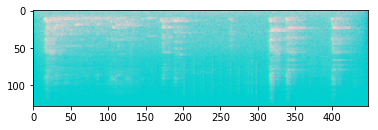

(128, 131, 3)


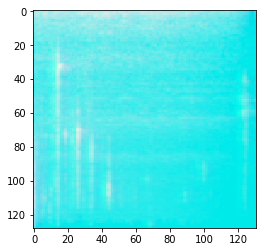

(128, 128, 3)


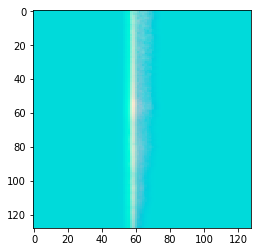

(128, 1623, 3)


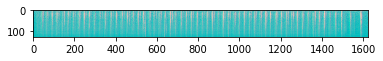

(128, 128, 3)


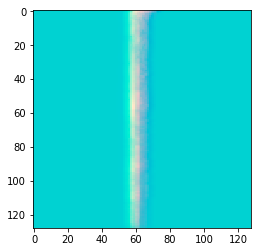

(128, 785, 3)


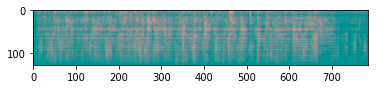

In [16]:
for i in range(0,6):
    a = np.asarray(X_train_curated[i:i+1])
    a = np.squeeze(a)
    print(a.shape)
    plt.imshow(a)
    plt.show()

The array above represents our spectrogram as an RGB image.
* Each 1x3 list represents **one pixel of our image**. Each value in this list represents respectively the Red, Green and Blue value (between 0 and 255) of the pixel (see image below). In our case, as our "color" is "one dimensional" (one pixel in our spectrogram is juste a real number representing the db value for a particular frequency at a particular time), our pixel color will be a shade of grey. Thus, the three RGB values will always be the same.
* Each list of 1x3 list represents **one horizontal line of our image**.
* **The whole array is our sound**, represented as a **gray-scaled image**. 

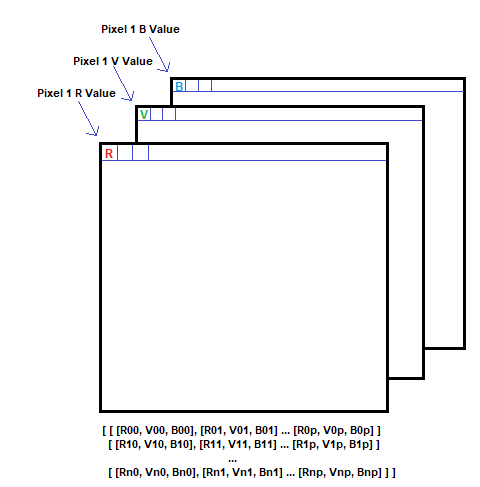

### **<div id="IV4">4. Normalizing images and performing data augmentation</div>**

Now that we have transformed our sound into images, we want them to have the same scale (for example, 128x128), for training purposes.
We will also perform **data augmentation**.

![test](https://cdn-images-1.medium.com/max/800/1*C8hNiOqur4OJyEZmC7OnzQ.png)

Data augmentation consists in making minor alterations to our existing dataset. Minor changes such as flips or translations or rotations. Our neural network would think these are distinct images.
A convolutional neural network that can robustly classify objects even if its placed in different orientations is said to have the property called invariance. More specifically, a CNN can be invariant to translation, viewpoint, size or illumination (Or a combination of the above).

This essentially is the premise of data augmentation. And augmentation can also help even with a large dataset; it can help to increase the amount of relevant data in your dataset. This is related to the way with which neural networks learn.

Of course, each change are not good for each type of data. For example, in our problem, we may not want to flip or rotate our image, since it would alter our sound in a bad way. But we can for exmple increase the brightness of the image (resulting in a louder sound I guess), or translate it.  


In [17]:
CUR_X_FILES, CUR_X = list(training_curated_df.fname.values), X_train_curated

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop
    time_dim, base_dim = x.size
    crop_x = 0
    #crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

In [18]:
#Batch size --> How many images are trained at one time. Lower it if you run out of memory
bs = 64
#Image size. Square images makes the learning process faster. We can increase the size of the images once our model is stable, in order to improve accuracy.
size = 128

#Performing data augmentation
tfms = get_transforms(do_flip=False, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)

#We put the transformed image data into /kaggle/working because ../input is a read-only directory.
src = (ImageList.from_csv('/kaggle/working', '../input/train_curated.csv', folder='../input/train_curated')
       .split_by_rand_pct(0.2).label_from_df(label_delim=','))

#Creates a databunch, because our cnn_learner below needs a databunch.
data = src.transform(tfms, size=size).databunch(bs=bs).normalize()

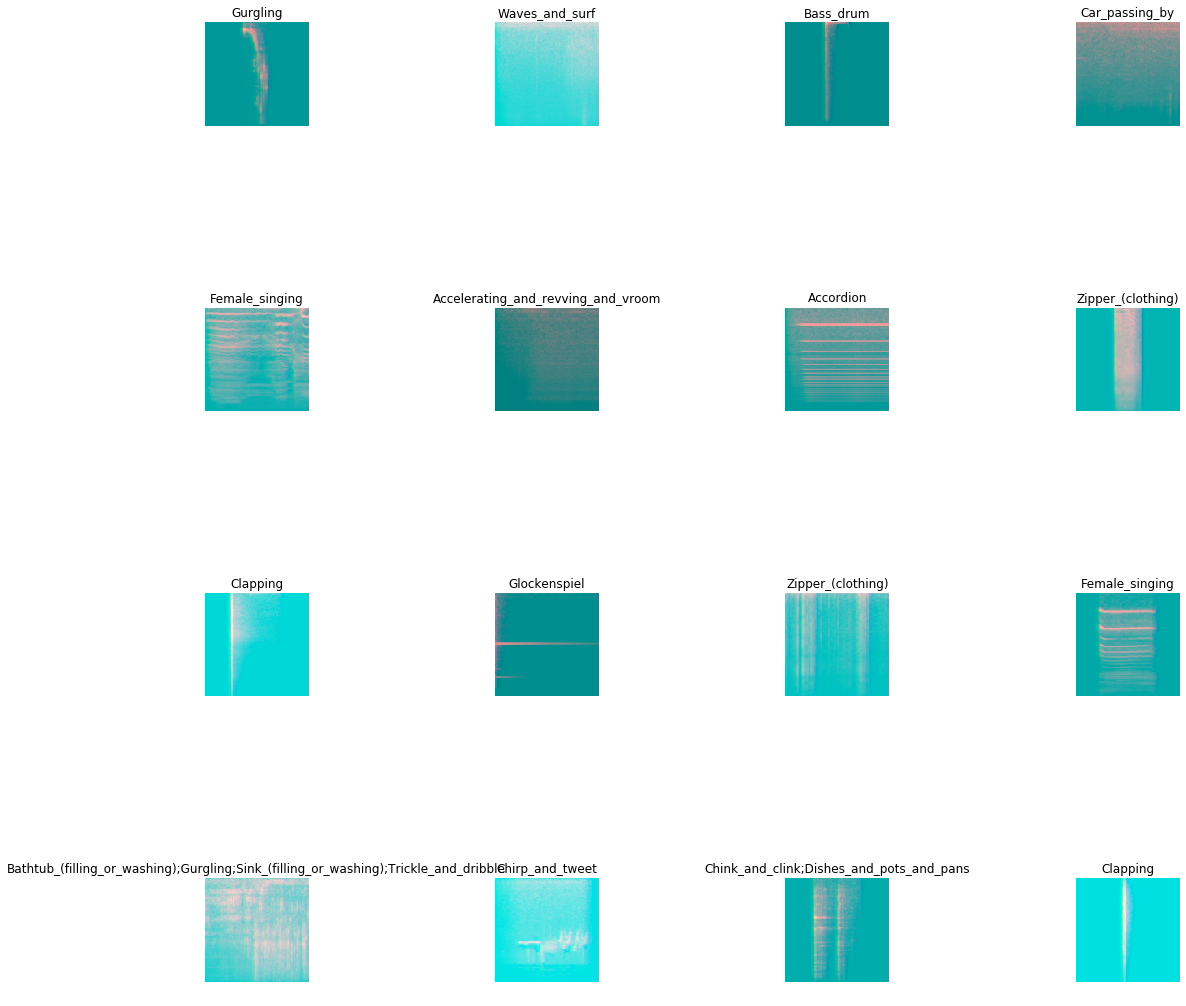

In [19]:
data.show_batch(4)

## **<div id="V">V. Model data</div>**

Now we will start training our model. We will use a **convolutional neural network** backbone and a fully connected head with a single hidden layer as a classifier. Our model takes images as input and will output the predicted probability for each of the categories.

We need to feed our learner with a databunch, and an architecture model. **resnet34** is a very good architecture to get started with. We can use **resnet50** to try getting better results once we are happy with our model. If we run out of memory while using resnet50, we can try to lower *bs* (batch size, how many images are trained at one time). Computing time will get a little bit longer, but we won't run out of memory anymore.

We have to set *pretrained* to *False*, as pretrained models are forbidden in this competition. For our metrics, we use *lwlrap* as it is the metric used in the competition.

We use **lr_find** to find the best learning rate for our model. It seems to start diverging when lr > 0,1, so we choose a value ten times lower, i.e. **lr = 0,01**.

We will train for 5 epochs (5 cycles through all our data).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


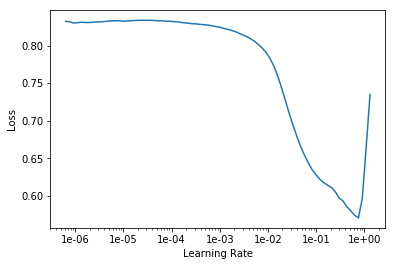

In [20]:
arch = models.resnet18

learn = cnn_learner(data, arch, pretrained=False, metrics=[lwlrap], wd = 0.1, ps = 0.5)

learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, 1e-2)
learn.save('first-attempt-128')

epoch,train_loss,valid_loss,lwlrap,time
0,0.417201,0.119256,0.091104,00:07
1,0.152264,0.071284,0.163420,00:07
2,0.092964,0.066135,0.244749,00:07
3,0.073582,0.061092,0.335871,00:07
4,0.065062,0.060038,0.349330,00:07


In [22]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,lwlrap,time
0,0.061242,0.057799,0.382422,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


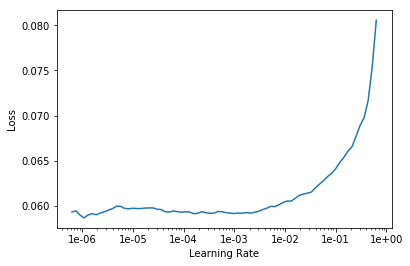

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit(20, slice(2e-3, 2e-4))
learn.save('second-attempt-128')

epoch,train_loss,valid_loss,lwlrap,time
0,0.060579,0.060284,0.370128,00:07
1,0.058513,0.055583,0.421644,00:07
2,0.057436,0.058637,0.406283,00:07
3,0.055834,0.054053,0.450441,00:07
4,0.054887,0.054194,0.459040,00:07
5,0.052952,0.053415,0.484399,00:07
6,0.050807,0.050186,0.506647,00:07
7,0.048958,0.065319,0.502154,00:07
8,0.047136,0.047342,0.546993,00:07
9,0.045311,0.050120,0.545320,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


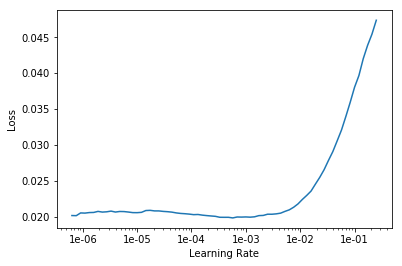

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit(20, slice(1e-3, 1e-4))
learn.save('third-attempt-128')

epoch,train_loss,valid_loss,lwlrap,time
0,0.018541,0.037278,0.660469,00:07
1,0.016834,0.037323,0.665776,00:07
2,0.015728,0.037933,0.652306,00:07
3,0.014461,0.037452,0.671123,00:07
4,0.013214,0.037438,0.661724,00:07
5,0.012055,0.037994,0.659648,00:07
6,0.011174,0.038134,0.658261,00:07
7,0.010355,0.038273,0.653875,00:07
8,0.009444,0.038285,0.656830,00:07
9,0.008639,0.037897,0.663937,00:07


### **<div id="VI">VI. New learner with increased size of images</div>**

Now that we have a pretty good learner fed with 128x128 images, let's: 
* Create a new databunch full of 256x256 images, 
* Keep the same learner as before ('third-attempt-128'),
* Replace the data inside the learner with my new 256x256 data,
* Freeze the model again (in order to train only the last few layers).

In [27]:
size = 256

#Creates a databunch, because our cnn_learner below needs a databunch.
data = src.transform(tfms, size=size).databunch(bs=bs).normalize(imagenet_stats)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


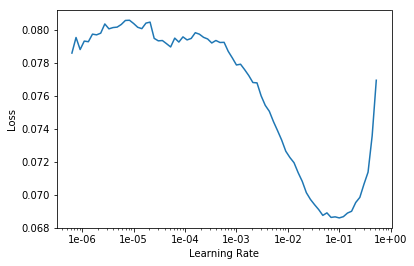

In [28]:
#Replace with 256x256 databunch
learn.data = data
#Freeze the model
learn.freeze()
#Plot lr_find()
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit(5, 3e-3)
learn.save('first-attempt-256')

epoch,train_loss,valid_loss,lwlrap,time
0,0.052731,0.042957,0.581847,00:27
1,0.042775,0.039562,0.622528,00:26
2,0.037362,0.037710,0.655038,00:27
3,0.033254,0.036024,0.674194,00:26
4,0.030121,0.037023,0.665815,00:26


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


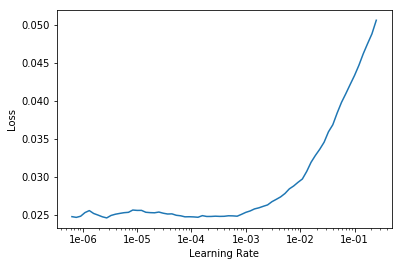

In [30]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit(7, slice(1e-3, 1e-4))
learn.save('second-attempt-256')

epoch,train_loss,valid_loss,lwlrap,time
0,0.028131,0.035862,0.673908,00:27
1,0.023413,0.036396,0.666503,00:27
2,0.019905,0.035386,0.680861,00:27
3,0.017127,0.037098,0.668944,00:27
4,0.014764,0.035255,0.696189,00:27
5,0.012973,0.035145,0.695517,00:27
6,0.011440,0.035342,0.698541,00:27


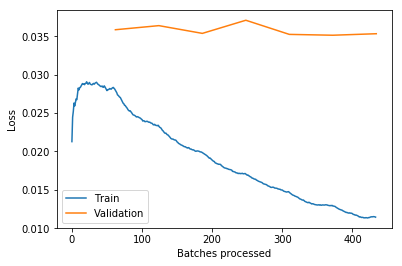

In [32]:
learn.recorder.plot_losses()

In [33]:
learn.fit_one_cycle(20, slice(5e-4, 5e-5), callbacks=[SaveModelCallback(learn, monitor='lwlrap', mode='max')])

epoch,train_loss,valid_loss,lwlrap,time
0,0.009043,0.034030,0.710721,00:28
1,0.008438,0.033899,0.714819,00:27
2,0.007912,0.033966,0.718787,00:27
3,0.007405,0.034670,0.709593,00:27
4,0.007180,0.034703,0.711341,00:27
5,0.006697,0.035285,0.702108,00:26
6,0.006473,0.035268,0.706943,00:27
7,0.006066,0.035427,0.707274,00:27
8,0.005565,0.036156,0.698903,00:27
9,0.005157,0.036312,0.702027,00:27


Better model found at epoch 0 with lwlrap value: 0.7107207179069519.
Better model found at epoch 1 with lwlrap value: 0.7148187756538391.
Better model found at epoch 2 with lwlrap value: 0.7187866568565369.


In [34]:
learn.export()

In [35]:
CUR_X_FILES, CUR_X = list(testing_df.fname.values), X_test

test = ImageList.from_csv(Path('/kaggle/working'), Path('../input/sample_submission.csv'), folder=Path('../input/test'))
learn = load_learner(Path('/kaggle/working'), test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

testing_df[learn.data.classes] = preds
testing_df.to_csv('submission.csv', index=False)
testing_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,Bus,Buzz,Car_passing_by,Cheering,Chewing_and_mastication,Child_speech_and_kid_speaking,Chink_and_clink,Chirp_and_tweet,Church_bell,Clapping,Computer_keyboard,Crackle,Cricket,Crowd,Cupboard_open_or_close,Cutlery_and_silverware,Dishes_and_pots_and_pans,Drawer_open_or_close,Drip,Electric_guitar,Fart,Female_singing,Female_speech_and_woman_speaking,Fill_(with_liquid),Finger_snapping,Frying_(food),Gasp,Glockenspiel,Gong,...,Harmonica,Hi-hat,Hiss,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Mechanical_fan,Meow,Microwave_oven,Motorcycle,Printer,Purr,Race_car_and_auto_racing,Raindrop,Run,Scissors,Screaming,Shatter,Sigh,Sink_(filling_or_washing),Skateboard,Slam,Sneeze,Squeak,Stream,Strum,Tap,Tick-tock,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0.000006,0.000024,0.000029,0.000387,0.000331,0.000094,8.230574e-05,0.002114,0.000938,0.000174,0.000900,0.003473,0.000012,0.000303,0.001143,0.000181,0.002035,0.008511,0.000030,0.000169,0.000153,0.003446,0.003031,0.000717,0.000023,0.003153,0.000555,0.000789,0.008816,5.216778e-05,0.000289,0.000020,0.000525,0.000147,0.001397,0.000571,0.001788,0.000360,0.000291,...,0.000776,6.848317e-03,0.011862,0.547766,0.000003,0.000337,0.000262,0.000139,0.000021,0.000101,0.000177,0.000157,0.000072,0.000144,0.000002,0.006475,0.000006,0.017654,0.000069,0.002924,0.000462,0.003484,0.000009,0.000023,0.000076,0.000114,0.000102,0.000035,0.000044,0.000032,0.000193,0.000437,0.001008,0.000077,0.008485,0.000583,0.000264,0.003839,0.000033,0.002433
1,0012633b.wav,0.000627,0.000197,0.000017,0.000135,0.015833,0.000222,4.160391e-04,0.009565,0.000217,0.000125,0.000379,0.014752,0.000553,0.000056,0.038054,0.003525,0.000559,0.001378,0.001431,0.000204,0.004203,0.046059,0.002052,0.000080,0.000416,0.000305,0.000077,0.007906,0.003186,6.991602e-04,0.000408,0.001267,0.002832,0.016524,0.000559,0.001640,0.001145,0.000187,0.000385,...,0.000141,1.241465e-04,0.016934,0.000767,0.002599,0.000196,0.001732,0.001154,0.000699,0.007659,0.001108,0.001631,0.003473,0.012459,0.000157,0.003496,0.033060,0.012643,0.000128,0.000415,0.001023,0.002288,0.000285,0.010812,0.001079,0.015149,0.000423,0.000038,0.004287,0.001172,0.014433,0.000564,0.011120,0.018517,0.004702,0.002570,0.001343,0.075696,0.000272,0.017217
2,001ed5f1.wav,0.001344,0.000014,0.000091,0.000205,0.002686,0.000070,2.609117e-05,0.000705,0.000184,0.000064,0.001511,0.000111,0.010136,0.000080,0.001874,0.000500,0.000255,0.000719,0.000310,0.000967,0.000384,0.002328,0.000151,0.000247,0.000243,0.000267,0.000428,0.002612,0.000076,6.182616e-05,0.000169,0.000052,0.000529,0.000364,0.000450,0.001463,0.000064,0.000214,0.000150,...,0.000042,6.189583e-06,0.002615,0.000086,0.001105,0.000072,0.001575,0.000038,0.002172,0.001758,0.010025,0.001332,0.001183,0.000520,0.000725,0.000065,0.087763,0.001580,0.000131,0.000177,0.000594,0.000173,0.013817,0.010952,0.007118,0.001569,0.000258,0.000119,0.003360,0.002999,0.000360,0.009353,0.000012,0.049205,0.000148,0.001915,0.001937,0.000125,0.000248,0.000578
3,00294be0.wav,0.000364,0.000028,0.000001,0.000020,0.000356,0.000137,3.270925e-05,0.005770,0.000013,0.006546,0.000313,0.000216,0.000146,0.000009,0.040747,0.000630,0.000362,0.000094,0.000063,0.000010,0.003620,0.001805,0.001248,0.000041,0.000214,0.000726,0.000390,0.007848,0.002657,2.553708e-05,0.000073,0.000048,0.000124,0.015653,0.000052,0.000777,0.003375,0.000003,0.000397,...,0.000020,3.053268e-04,0.004850,0.000167,0.001572,0.000062,0.000916,0.000170,0.000183,0.018598,0.000192,0.000622,0.001301,0.193715,0.000043,0.001615,0.000328,0.006355,0.000041,0.000060,0.000505,0.011847,0.000035,0.000699,0.001998,0.001725,0.000393,0.000001,0.002157,0.000126,0.018615,0.000097,0.004567,0.001340,0.005256,0.0003